In [227]:
import time
import numpy as np
import tensorflow.compat.v1 as tf
import os
tf.disable_v2_behavior()
#import utils

资源准备：

key

文本

In [228]:
workey=np.load('../../毕设/joycity_shop_list2_key.npy',allow_pickle=True)
workey = list(set(workey))
int_to_vocab = {j:i for i,j in zip(workey,range(len(workey)))}
word2int = {int_to_vocab[i]:i for i in int_to_vocab}

In [229]:
for root,dirs,files in os.walk("./shopdata/"): 
    filelist = (files)

textf_list = []
for dirr in filelist:
    with open('./shopdata/'+dirr) as f:
        textf_list.append(f.read())

alllist = []
for  shops in textf_list:
    for com in shops.split('\n'):
        if len (com.split('//')) ==3:
            alllist.append(com.split('//')[2])
# alllist 是总评论集合

In [280]:
import random

In [281]:
alllist = np.load('../../毕设/joycity_shop_list2.npy',allow_pickle=True)

In [282]:
len(alllist)

55976

In [283]:
len(word2int)

298

In [284]:
train_wordslist = []
for wo in alllist:
    train_words =[word2int[i] for i in wo if (i in word2int) ]
    if len(train_words)>2:
        train_wordslist.append(train_words)
    
# 转换成为数字

In [285]:
len(train_wordslist)

55976

In [286]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    #print(R)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

In [287]:
def get_batches(wordsl, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    #n_batches = len(words)//batch_size
    
    # only full batches
    #words = words[:n_batches*batch_size]
    all_batch = []
    for words in ( (wordsl)):
        if len(words)>batch_size:
            n_batches = len(words)//batch_size
            words = words[:n_batches*batch_size]
            for idx in range(0, len(words), batch_size):
                x, y = [], []
                batch = words[idx:idx+batch_size]
                for ii in range(len(batch)):
                    batch_x = batch[ii]
                    batch_y = get_target(batch, ii, window_size)
                    y.extend(batch_y)
                    x.extend([batch_x]*len(batch_y))
                yield x, y
        else:
            x, y = [], []
            batch = words
            for ii in range(len(batch)):
                batch_x = batch[ii]
                batch_y = get_target(batch, ii, window_size)
                y.extend(batch_y)
                x.extend([batch_x]*len(batch_y))
           
            yield x, y

In [288]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, 1], name='labels')

In [289]:
n_vocab = len(word2int)
n_embedding = 5# Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)
n_vocab

298

In [290]:
# Number of negative labels to sample
n_sampled = 5
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

In [291]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 5# Random set of words to evaluate similarity on.
    valid_window = 200
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [292]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints_close

mkdir: cannot create directory ‘checkpoints_close’: File exists


In [296]:
epochs = 40
batch_size = 1000
window_size = 10
loglist = []
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_wordslist, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 10000 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                loglist.append(loss/100)
                start = time.time()
            
            if iteration % 40000 == 0:
                try:
                    # note that this is expensive (~20% slowdown if computed every 500 steps)
                    sim = similarity.eval()
                    for i in range(valid_size):
                        valid_word = int_to_vocab[valid_examples[i]]
                        top_k = 4 # number of nearest neighbors
                        nearest = (-sim[i, :]).argsort()[1:top_k+1]
                        log = 'Nearest to %s:' % valid_word
                        for k in range(top_k):

                            close_word = int_to_vocab[nearest[k]]
                            log = '%s %s,' % (log, close_word)
                        print(log)
                        
                except:
                    print('error')
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints_close/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/40 Iteration: 10000 Avg. Training loss: 104.1934 0.0819 sec/batch
Epoch 1/40 Iteration: 20000 Avg. Training loss: 90.8278 0.0771 sec/batch
Epoch 1/40 Iteration: 30000 Avg. Training loss: 88.1595 0.0704 sec/batch
Epoch 1/40 Iteration: 40000 Avg. Training loss: 86.8302 0.0712 sec/batch
error
Epoch 1/40 Iteration: 50000 Avg. Training loss: 87.1959 0.0794 sec/batch
Epoch 2/40 Iteration: 60000 Avg. Training loss: 86.7821 0.0364 sec/batch
Epoch 2/40 Iteration: 70000 Avg. Training loss: 86.1723 0.0781 sec/batch
Epoch 2/40 Iteration: 80000 Avg. Training loss: 84.6192 0.0727 sec/batch
error
Epoch 2/40 Iteration: 90000 Avg. Training loss: 85.0343 0.0748 sec/batch
Epoch 2/40 Iteration: 100000 Avg. Training loss: 86.1457 0.0734 sec/batch
Epoch 2/40 Iteration: 110000 Avg. Training loss: 84.1450 0.0774 sec/batch
Epoch 3/40 Iteration: 120000 Avg. Training loss: 85.1703 0.0644 sec/batch
error
Epoch 3/40 Iteration: 130000 Avg. Training loss: 84.5609 0.0741 sec/batch
Epoch 3/40 Iteration: 140000

Epoch 20/40 Iteration: 1090000 Avg. Training loss: 83.3393 0.0828 sec/batch
Epoch 20/40 Iteration: 1100000 Avg. Training loss: 83.3417 0.0815 sec/batch
Epoch 20/40 Iteration: 1110000 Avg. Training loss: 82.8562 0.0813 sec/batch
Epoch 21/40 Iteration: 1120000 Avg. Training loss: 83.5616 0.0038 sec/batch
error
Epoch 21/40 Iteration: 1130000 Avg. Training loss: 83.2688 0.0817 sec/batch
Epoch 21/40 Iteration: 1140000 Avg. Training loss: 84.1728 0.0781 sec/batch
Epoch 21/40 Iteration: 1150000 Avg. Training loss: 82.1920 0.0750 sec/batch
Epoch 21/40 Iteration: 1160000 Avg. Training loss: 83.2657 0.0834 sec/batch
error
Epoch 21/40 Iteration: 1170000 Avg. Training loss: 83.3181 0.0842 sec/batch
Epoch 22/40 Iteration: 1180000 Avg. Training loss: 83.2999 0.0363 sec/batch
Epoch 22/40 Iteration: 1190000 Avg. Training loss: 83.1956 0.0799 sec/batch
Epoch 22/40 Iteration: 1200000 Avg. Training loss: 82.8542 0.0808 sec/batch
error
Epoch 22/40 Iteration: 1210000 Avg. Training loss: 83.3769 0.0834 sec/

Epoch 39/40 Iteration: 2150000 Avg. Training loss: 82.8238 0.0871 sec/batch
Epoch 39/40 Iteration: 2160000 Avg. Training loss: 82.2322 0.0881 sec/batch
error
Epoch 39/40 Iteration: 2170000 Avg. Training loss: 82.4323 0.0852 sec/batch
Epoch 39/40 Iteration: 2180000 Avg. Training loss: 83.0537 0.0867 sec/batch
Epoch 40/40 Iteration: 2190000 Avg. Training loss: 83.0691 0.0649 sec/batch
Epoch 40/40 Iteration: 2200000 Avg. Training loss: 83.3477 0.0875 sec/batch
error
Epoch 40/40 Iteration: 2210000 Avg. Training loss: 82.6238 0.0917 sec/batch
Epoch 40/40 Iteration: 2220000 Avg. Training loss: 83.4537 0.0854 sec/batch
Epoch 40/40 Iteration: 2230000 Avg. Training loss: 83.5407 0.0881 sec/batch


In [297]:
np.save('w2v44_shop_10',embed_mat)

In [170]:
pd.DataFrame(embed_mat).to_csv('matshop.csv',index = False)

IndexError: index 298 is out of bounds for axis 0 with size 298

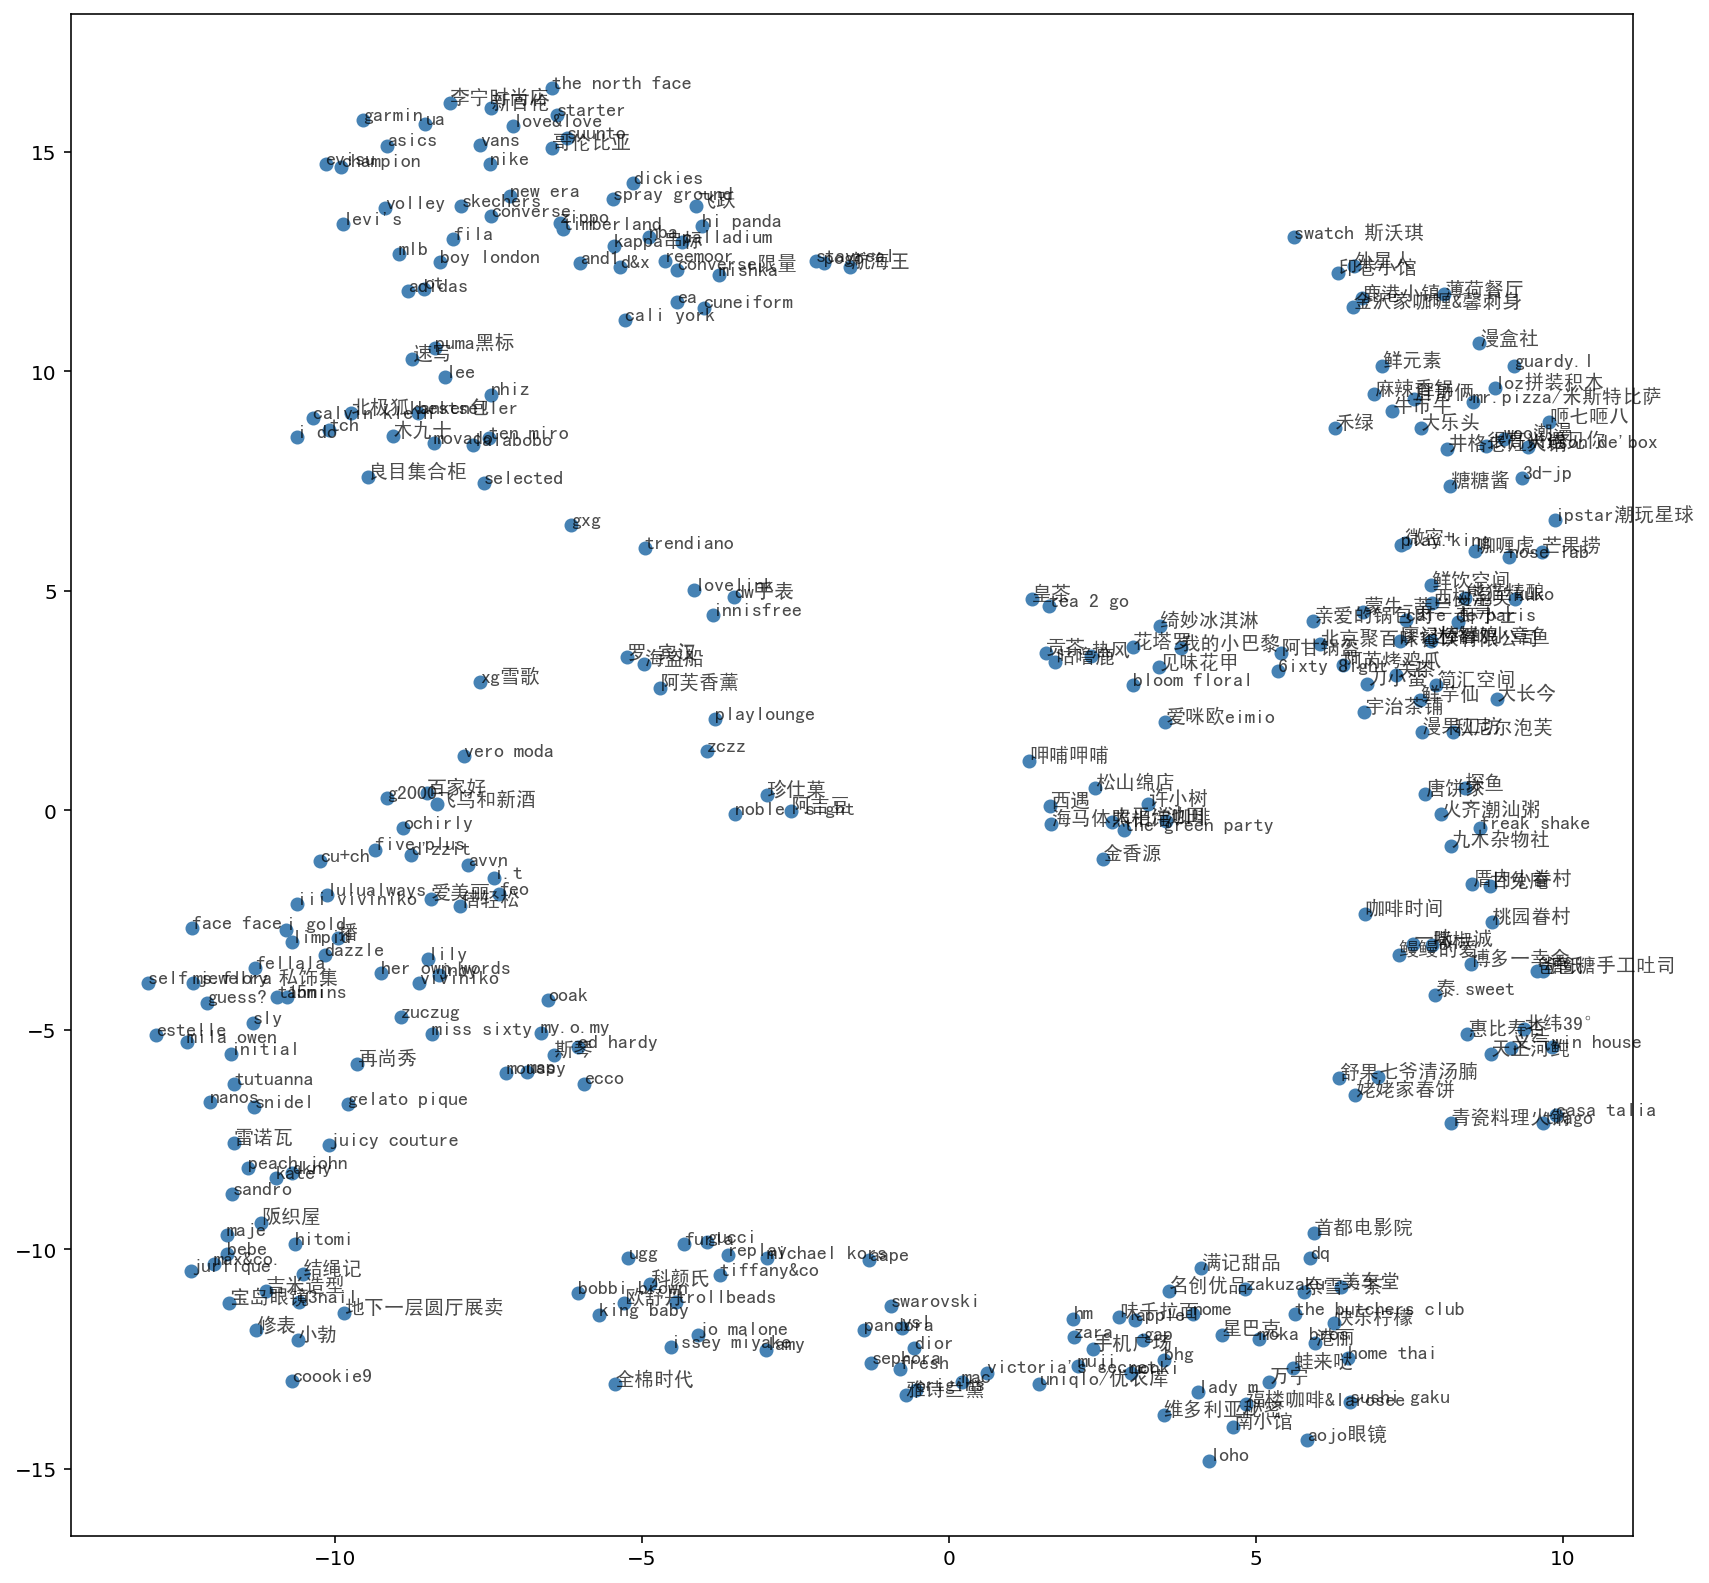

In [245]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

viz_words = 318
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:, :])

import matplotlib
from matplotlib import font_manager
my_font =  {'family' : 'MicroSoft YaHei',  'weight' : 'bold', 'size'   : 'larger'}
matplotlib.rc("font",)
my_font = font_manager.FontProperties(fname="simhei.ttf")





fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7,fontproperties=my_font)

In [146]:
# 计算相似列表
# 
def cos_sim(vector_a, vector_b):
    """
    计算两个向量之间的余弦相似度
    :param vector_a: 向量 a 
    :param vector_b: 向量 b
    :return: sim
    """
    vector_a = np.mat(vector_a)
    vector_b = np.mat(vector_b)
    num = float(vector_a * vector_b.T)
    denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    return sim

In [147]:
cos_sim(embed_mat[1,:],embed_mat[72,:])

0.4763902425765991

In [148]:
sim_corr  =[]
for i in range(len(int_to_vocab)):
    sim_corronek  =[]
    for j in range(len(int_to_vocab)):
        midl = [int_to_vocab[i],int_to_vocab[j],cos_sim(embed_mat[i,:],embed_mat[j,:])]
        sim_corronek.append(midl)
    sim_corr.append(sim_corronek)

In [149]:
shopdflist = []
for i in range(len(sim_corr)):
    df_one_shop = pd.DataFrame((sim_corr[i])).sort_values(by = 2,ascending=False).reset_index(drop = True).reset_index()
    df_one_shop['rank'] =5
    df_one_shop['rank'] = df_one_shop['rank']  -df_one_shop['index']
    df_one_shop = df_one_shop[df_one_shop['rank']>=0]
    shopdflist.append(df_one_shop)

In [150]:
sim_df = pd.concat(shopdflist)[[0,1,'rank']].reset_index(drop = True)

In [151]:
import networkx as nx
sim_df=sim_df.rename(columns={0:'source'})
sim_df=sim_df.rename(columns={1:'target'})
sim_df=sim_df.rename(columns={2:'weight'})
G = nx.from_pandas_edgelist(sim_df,edge_attr=True)
nx.write_gexf(G,'my_rank_node.gexf')

In [152]:
import pandas as pd
allcor = []
for i in sim_corr:
    for j in i:
        allcor.append(j)
sim_df = pd.DataFrame(allcor)

In [153]:
sim_df=sim_df.rename(columns={0:'source'})
sim_df=sim_df.rename(columns={1:'target'})
sim_df=sim_df.rename(columns={2:'weight'})


In [154]:
G = nx.from_pandas_edgelist(sim_df,edge_attr=True)
nx.write_gexf(G,'my_corr_node.gexf')

In [155]:
sim_df.to_csv('sim_csv.csv')

In [156]:
shopdic = {i[0][0]:list(i[1])[1:] for i in shopdflist}

In [157]:
shopdic

{'zczz': ['播', 'iii viviniko', 'the north face', 'jnby', 'lulualways'],
 '鲜元素': ['咖喱虎', 'play.king', 'calvin klein', 'tch', 'nba'],
 'jo malone': ['origins', 'ysl', '欧舒丹', 'viviniko', 'her own words'],
 'timberland': ['miss sixty', 'adidas', 'dw手表', "levi's", '李宁时尚店'],
 'boy london': ['ten miro', 'hi panda', 'mlb', 'cali york', 'tch'],
 'my.o.my': ['nanos', 'trollbeads', 'gucci', '吉米造型', 'evisu'],
 '播': ['zczz', 'jnby', 'gelato pique', 'g2000', 'cu+ch'],
 '地下一层圆厅展卖': ['bhg', '简汇空间', 'mac', '满记甜品', 'pogo'],
 '青瓷料理火锅': ['lady m', '维多利亚秘密', 'loho', 'new era', '牛市牛'],
 'ua': ['asics', 'volley', '宇治茶铺', 'adidas', 'suunto'],
 'ea': ['d&x', '牛市牛', 'gucci', '印巷小馆', '雅诗兰黛'],
 '咕噜鹿': ['太平洋咖啡', 'kappa串标', '新百伦', '贡茶', 'self jewelry 私饰集'],
 '欧舒丹': ['jo malone', 'ysl', '科颜氏', '万宁', '宝岛眼镜'],
 '鳗鳗的爱': ['名创优品', 'lamy', '首都电影院', 'lily', 'lee'],
 'gxg': ['trendiano', 'selected', 'vero moda', '芒果捞', 'skechers'],
 '结绳记': ['lalabobo', '再尚秀', '斯琴', 'gelato pique', 'spray ground'],
 '倍轻松': ['海马体照相馆', '漫盒社', 

In [246]:
from matplotlib import pyplot
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster   import KMeans
from scipy import sparse
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import pickle
from sklearn.externals import joblib


#加载数据

x = embed_mat
print(x)


x1 = np.array(x)
print("x1:",x1)
xx = preprocessing.scale(x1)

print("preprocessing.scale xx:",xx)
scolit = []
for i in range(3,50):
    num_clusters = i


    clf = KMeans(n_clusters=num_clusters,  n_init=1, n_jobs = 1,verbose=1) #job=-1 并行化处理
    clf.fit(xx)
    #print("label:",clf.labels_)
    labels = clf.labels_
    #score是轮廓系数
    score = metrics.silhouette_score(xx, labels)
    # clf.inertia_用来评估簇的个数是否合适，距离越小说明簇分的越好
    scolit.append([clf.inertia_,score])
    #print ("clf.inertia_",clf.inertia_)
    #print (score)

[[-5.49746394e-01  7.63347089e-01 -3.39234561e-01]
 [ 9.54492688e-01 -1.35420471e-01 -2.65715867e-01]
 [-6.20567501e-01 -6.80390239e-01  3.89827013e-01]
 [ 4.43055362e-01  4.55684453e-01  7.72045076e-01]
 [ 2.42004454e-01  3.17189097e-01  9.16965008e-01]
 [-8.26462388e-01  1.16347603e-01  5.50838590e-01]
 [-9.16121721e-01  3.95046115e-01  6.82608411e-02]
 [-5.59569657e-01 -1.82901278e-01 -8.08349490e-01]
 [ 2.55621165e-01 -8.19868445e-01 -5.12321830e-01]
 [ 5.51607668e-01 -5.04692234e-02  8.32575321e-01]
 [ 3.69376242e-01  7.51011729e-01  5.47304749e-01]
 [-6.23312732e-03  8.61426115e-01 -5.07844746e-01]
 [-7.89076924e-01 -5.14872372e-01  3.35058033e-01]
 [ 6.42792881e-01 -2.98174769e-01 -7.05626786e-01]
 [-1.07580855e-01  8.87542009e-01  4.47990566e-01]
 [-7.94095933e-01 -2.01593935e-01 -5.73386133e-01]
 [-8.07690501e-01  4.56205964e-01  3.73513222e-01]
 [ 2.68062860e-01  9.10822630e-01 -3.13917994e-01]
 [ 5.13413429e-01  4.17507529e-01 -7.49729276e-01]
 [ 7.29864359e-01  4.54118371e-

/home/wangls/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 443.93298
start iteration
done sorting
end inner loop
Iteration 1, inertia 437.42657
start iteration
done sorting
end inner loop
Iteration 2, inertia 436.73676
start iteration
done sorting
end inner loop
Iteration 3, inertia 436.73676
center shift 0.000000e+00 within tolerance 9.999997e-05
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 298.05182
start iteration
done sorting
end inner loop
Iteration 1, inertia 287.36572
start iteration
done sorting
end inner loop
Iteration 2, inertia 285.3803
start iteration
done sorting
end inner loop
Iteration 3, inertia 284.75476
start iteration
done sorting
end inner loop
Iteration 4, inertia 284.66498
start iteration
done sorting
end inner loop
Iteration 5, inertia 284.66498
center shift 0.000000e+00 within tolerance 9.999997e-05
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 27

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 100.95928
start iteration
done sorting
end inner loop
Iteration 1, inertia 94.5496
start iteration
done sorting
end inner loop
Iteration 2, inertia 91.04733
start iteration
done sorting
end inner loop
Iteration 3, inertia 89.44471
start iteration
done sorting
end inner loop
Iteration 4, inertia 87.526825
start iteration
done sorting
end inner loop
Iteration 5, inertia 86.18829
start iteration
done sorting
end inner loop
Iteration 6, inertia 85.992744
start iteration
done sorting
end inner loop
Iteration 7, inertia 85.808945
start iteration
done sorting
end inner loop
Iteration 8, inertia 85.74275
start iteration
done sorting
end inner loop
Iteration 9, inertia 85.74275
center shift 0.000000e+00 within tolerance 9.999997e-05
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 95.089005
start iteration
done sorting
end inner loop
Iteration 1, inertia 89.39763
star

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 34.626328
start iteration
done sorting
end inner loop
Iteration 1, inertia 31.420998
start iteration
done sorting
end inner loop
Iteration 2, inertia 29.972687
start iteration
done sorting
end inner loop
Iteration 3, inertia 29.742237
start iteration
done sorting
end inner loop
Iteration 4, inertia 29.425072
start iteration
done sorting
end inner loop
Iteration 5, inertia 29.399668
start iteration
done sorting
end inner loop
Iteration 6, inertia 29.399668
center shift 0.000000e+00 within tolerance 9.999997e-05
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 35.19401
start iteration
done sorting
end inner loop
Iteration 1, inertia 32.405075
start iteration
done sorting
end inner loop
Iteration 2, inertia 31.279585
start iteration
done sorting
end inner loop
Iteration 3, inertia 30.799189
start iteration
done sorting
end inner loop
Iteration 4, inertia 30.5610

In [216]:
from matplotlib import pyplot
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster   import KMeans
from scipy import sparse
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import pickle
from sklearn.externals import joblib


#加载数据

x = embed_tsne
print(x)


x1 = np.array(x)
print("x1:",x1)
xx = preprocessing.scale(x1)

print("preprocessing.scale xx:",xx)
scolit = []

num_clusters = 9


clf = KMeans(n_clusters=num_clusters,  n_init=1, n_jobs = 1,verbose=1) #job=-1 并行化处理
clf.fit(xx)
#print("label:",clf.labels_)
labels = clf.labels_
#score是轮廓系数
score = metrics.silhouette_score(xx, labels)
# clf.inertia_用来评估簇的个数是否合适，距离越小说明簇分的越好
scolit.append([clf.inertia_,score])
#print ("clf.inertia_",clf.inertia_)
#print (score)

[[ -6.0704336   -4.2266984 ]
 [ 18.777624    -2.1529462 ]
 [  5.8693237   13.270834  ]
 [ -9.382211    -0.6214984 ]
 [  1.4165593    0.97799444]
 [  1.2143201   11.013798  ]
 [ -6.078185    -4.0965595 ]
 [ -6.347582     5.589479  ]
 [  9.015823    -8.954426  ]
 [ -8.795862    -5.6106505 ]
 [ -1.2758533    1.7021095 ]
 [-11.636093   -12.194145  ]
 [  6.4832087   12.494709  ]
 [ 12.077309    -7.8283544 ]
 [ 17.399656   -10.40955   ]
 [  4.17219     -3.2130563 ]
 [ 11.835632     6.868116  ]
 [-11.556924     5.2954936 ]
 [ 13.38875      0.47800723]
 [ 17.991436    -1.9888281 ]
 [ -4.3559074    7.0021553 ]
 [  8.096861    -4.8110776 ]
 [ 16.14714      3.6665525 ]
 [ -9.843045    -3.8722918 ]
 [ -3.3002126   -3.8806014 ]
 [-13.2671175   -7.103754  ]
 [ -7.994258     3.7712991 ]
 [ -6.420916   -12.552975  ]
 [-10.238811    -6.504771  ]
 [-13.380571     0.34892595]
 [  0.3579067   -1.8180511 ]
 [  2.10404     10.263996  ]
 [ -7.117508    -8.2419    ]
 [ 17.544743     4.221234  ]
 [ 12.242644  

/home/wangls/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/wangls/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


[[-8.46586645e-01 -4.63781208e-01]
 [ 2.09727478e+00 -2.13908866e-01]
 [ 5.67970157e-01  1.64454639e+00]
 [-1.23894787e+00 -2.93803494e-02]
 [ 4.04310897e-02  1.63347095e-01]
 [ 1.64708924e-02  1.37258959e+00]
 [-8.47504973e-01 -4.48100388e-01]
 [-8.79421651e-01  7.18998015e-01]
 [ 9.40750122e-01 -1.03343856e+00]
 [-1.16948032e+00 -6.30537510e-01]
 [-2.78551131e-01  2.50597775e-01]
 [-1.50597537e+00 -1.42380154e+00]
 [ 6.40699863e-01  1.55102885e+00]
 [ 1.30345809e+00 -8.97754967e-01]
 [ 1.93402064e+00 -1.20877051e+00]
 [ 3.66903096e-01 -3.41644585e-01]
 [ 1.27482569e+00  8.73064637e-01]
 [-1.49659586e+00  6.83574855e-01]
 [ 1.45883048e+00  1.03102222e-01]
 [ 2.00413156e+00 -1.94133788e-01]
 [-6.43459022e-01  8.89215410e-01]
 [ 8.31876516e-01 -5.34194708e-01]
 [ 1.78562951e+00  4.87299114e-01]
 [-1.29354501e+00 -4.21077728e-01]
 [-5.18386066e-01 -4.22078967e-01]
 [-1.69921029e+00 -8.10445786e-01]
 [-1.07451081e+00  4.99920368e-01]
 [-8.88109863e-01 -1.46703792e+00]
 [-1.34043312e+00 -7

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 78.95611
start iteration
done sorting
end inner loop
Iteration 1, inertia 75.92132
start iteration
done sorting
end inner loop
Iteration 2, inertia 75.039055
start iteration
done sorting
end inner loop
Iteration 3, inertia 74.61864
start iteration
done sorting
end inner loop
Iteration 4, inertia 74.15469
start iteration
done sorting
end inner loop
Iteration 5, inertia 73.53233
start iteration
done sorting
end inner loop
Iteration 6, inertia 73.21083
start iteration
done sorting
end inner loop
Iteration 7, inertia 73.09589
start iteration
done sorting
end inner loop
Iteration 8, inertia 72.98191
start iteration
done sorting
end inner loop
Iteration 9, inertia 72.94876
start iteration
done sorting
end inner loop
Iteration 10, inertia 72.91483
start iteration
done sorting
end inner loop
Iteration 11, inertia 72.88484
start iteration
done sorting
end inner loop
Iteration 12, inertia 72.66304
start iter

In [273]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

viz_words = 318
tsne = TSNE(3)
embed_tsne = tsne.fit_transform(embed_mat1[:, :])



In [258]:
from IPython import display
from mpl_toolkits.mplot3d import Axes3D


In [269]:
embed_mat1 = np.load('w2v44_shop.npy')
embed_mat1

array([[ 0.05435298, -0.0110003 ,  0.00314222, ..., -0.18974686,
        -0.03659177,  0.06573669],
       [-0.05477818, -0.01881258, -0.00418535, ...,  0.02220518,
         0.00281319, -0.13855375],
       [ 0.03798309, -0.02938727, -0.01197538, ..., -0.03728145,
         0.10833879, -0.11936876],
       ...,
       [-0.0638438 ,  0.00608985,  0.02189664, ...,  0.05183045,
        -0.00314443,  0.07880589],
       [ 0.00508387,  0.00619126, -0.13184965, ..., -0.22112936,
        -0.08002243,  0.07836034],
       [-0.09431177, -0.07349646,  0.10682875, ..., -0.01486027,
         0.04568756, -0.05380176]], dtype=float32)

In [277]:
np.save('i2wdic_copy1',int_to_vocab)

<IPython.core.display.Javascript object>


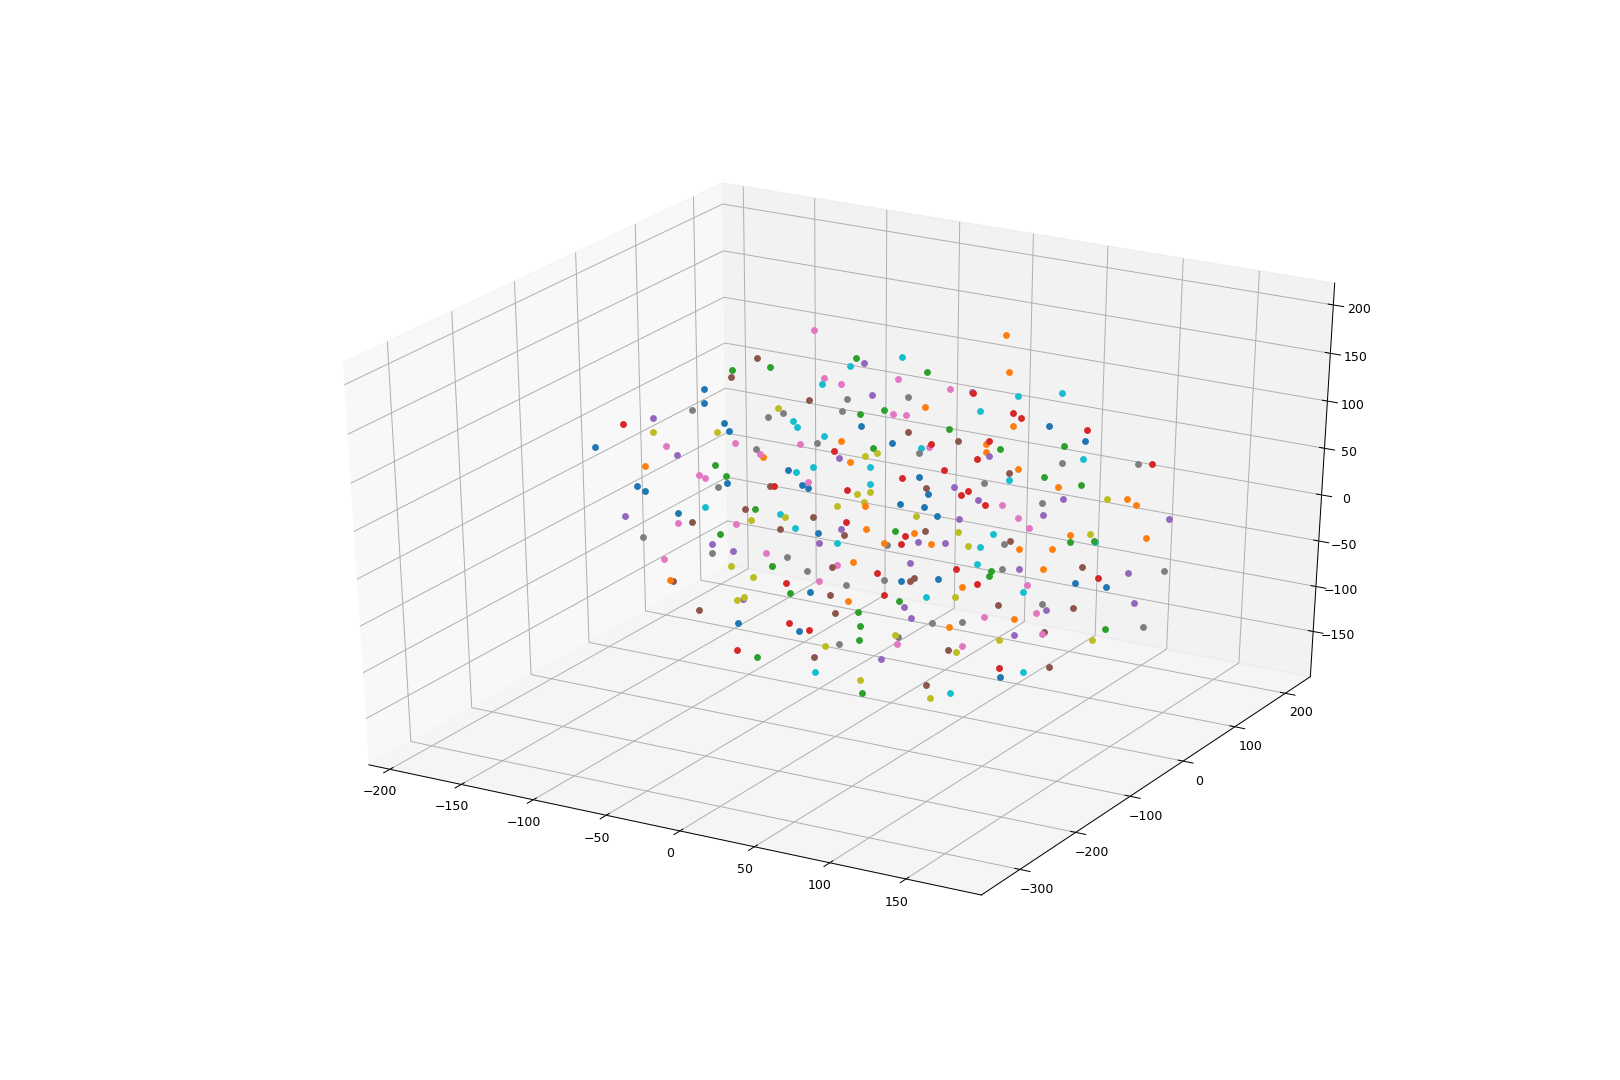

In [275]:


%matplotlib notebook
plt.ion() #打开交互式

plt.figure(figsize=((18,12)))

ax = plt.axes(projection='3d')
for idx in range(298):
    ax.scatter3D(embed_tsne[idx,0], embed_tsne[idx,1], embed_tsne[idx,2])

    #plt.scatter(*embed_tsne[idx, :],color= colorl[idx])
    #ax.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1],embed_mat1[idx, 2]), alpha=0.7,fontproperties=my_font)

In [218]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 9))
coldic = {i:colors[i] for i in range(9)}
    

In [255]:
colorl = np.array([coldic[i].tolist() for i in labels])

KeyError: 33

<IPython.core.display.Javascript object>


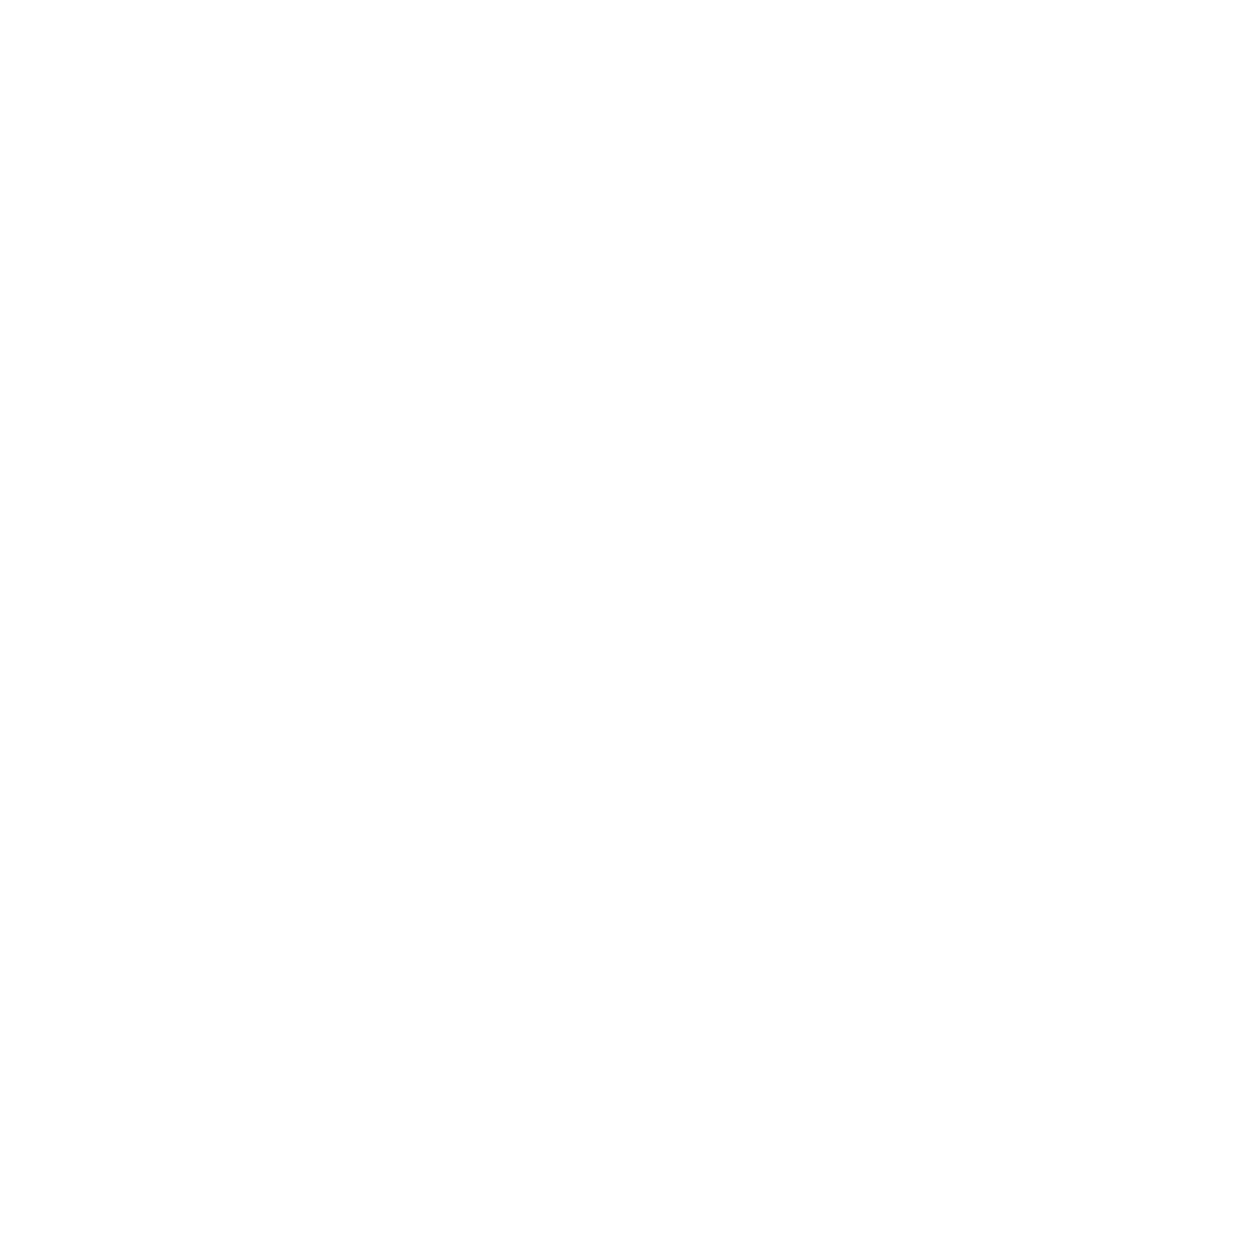

<IPython.core.display.Javascript object>


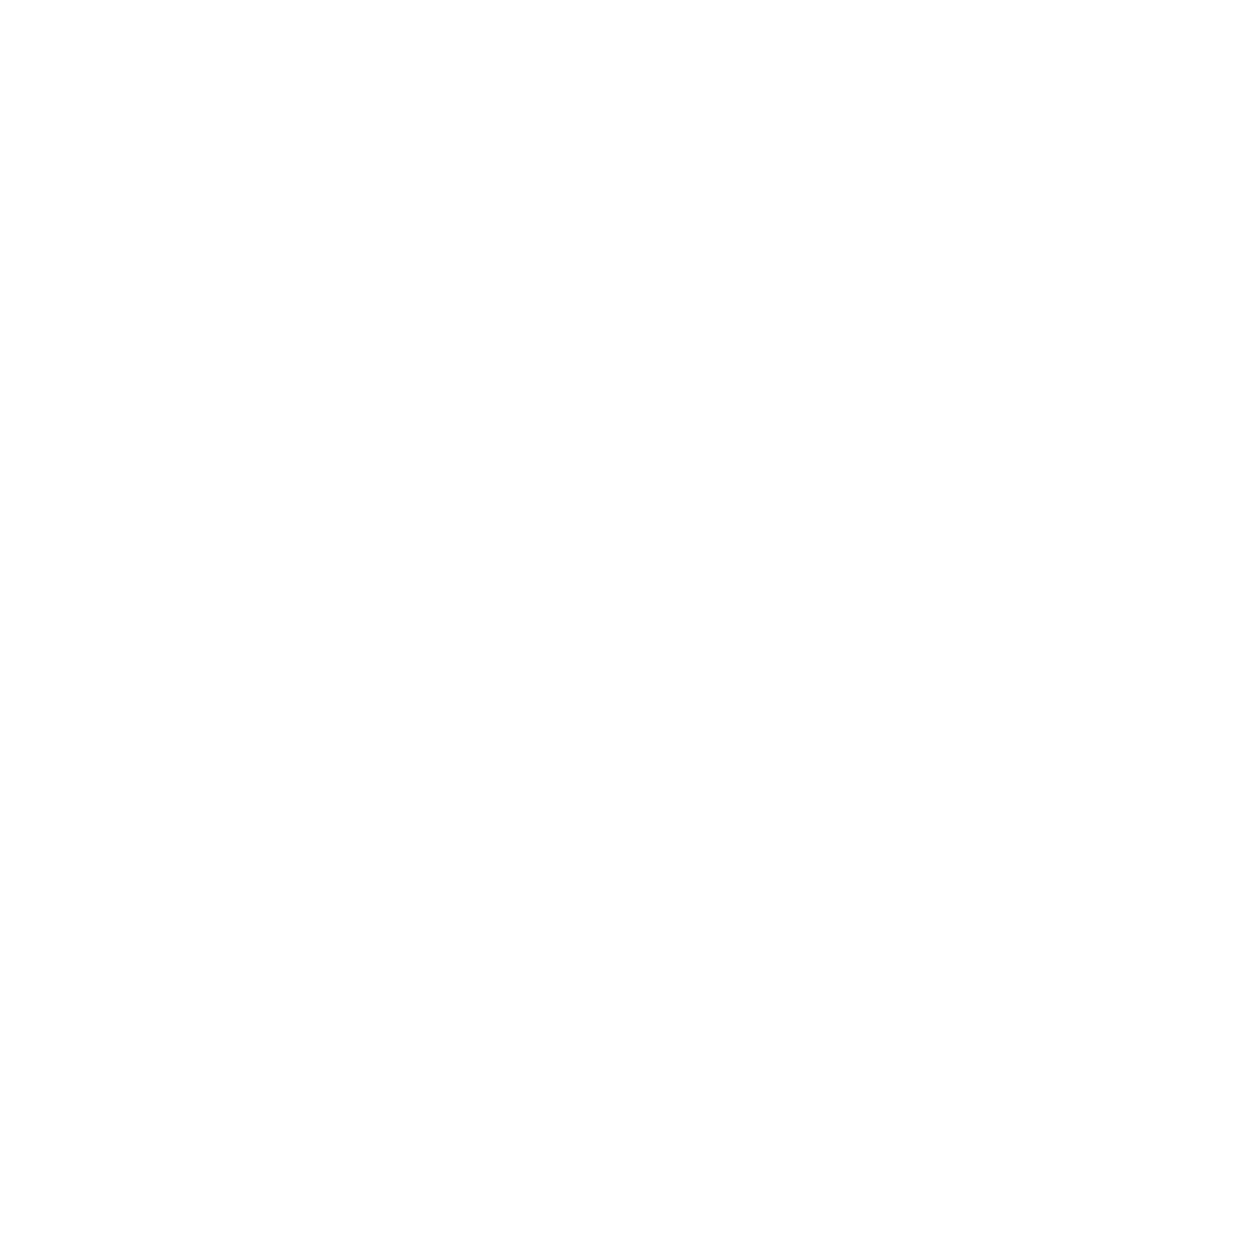

In [256]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(298):
    plt.scatter(*embed_tsne[idx, :],color= colorl[idx])
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7, color= colorl[idx],fontproperties=my_font)

In [212]:
!git clone https://github.com/JRC1995/Self-Organizing-Map.git

Cloning into 'Self-Organizing-Map'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), done.
